In [1]:
import numpy as np
import pandas as pd

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6

from hebbian import GenerateArrayFromImage, Hebbian
output_notebook()

Loading BokehJS ...

# About this notebook
Skimmig [The computational beauty of nature](https://mitpress.mit.edu/books/computational-beauty-nature) I came across this very cool idea of Hebbian Learning which may explain, at least in a simple way, how associative memory works.

## Neural network
We will build a neural network with a single layer where all the neurons are mutually connected one another. Then we will store a memory and try to recall it from partial information, kind of corrupted memomry.

## Neurons that fire together, wire together
The key take away here is that these memories are stored in form of weights between the neurons such that if two neurons are active at the same time their connection gets reinforced whereas if they don't their connection weakens. This is popularly known as: *Neurons that fire together, wire together* and allows to progressively refine inputs until they converge to some stored memory.

## How weights are stored
Given that all the neurons are connected together, a single neuron will get $n-1$ inputs where $n$ is the amount of neurons. Each of the inputs will have a weight equal to:
$$w_{ij}=\frac{1}{n}x_i\cdot x_j$$

Where:
- $w_{ij}$ is the weight of the connection between the current neuron $i$ and some neuron else $j$
- $n$, as said, is the number of neurons in the system.
- $x_i$ is the activation value of current neuron. When setting up the network that effectively means, the information we want to store in binary form, either $(-1, 1)$. Every neuron will deal with one bit of information.
- $x_j$ is the activation value of the connected neuron also in binary form, either $(-1, 1)$

Let's see a numerical example of this algebra:

In [3]:
initial_activation_values = np.array([1, -1, 1])  # A, B, C

# This below represents the weights between neurons
1/3 * np.array([
    [np.nan, -1, 1],  # AB, AC
    [-1, np.nan, -1],  # BA, BC
    [1, -1, np.nan]  # CA, CB
])

array([[        nan, -0.33333333,  0.33333333],
       [-0.33333333,         nan, -0.33333333],
       [ 0.33333333, -0.33333333,         nan]])

## How the network is updated
Now that we have the network set up, we have to deal with the update rule that defines how activation values for neurons evolve over time from an initial partial information to a converged state whether it means recalling the correct memory or not.



# Test the convergence of random arrays
We tested small arrays in the tests and they worked well. Now it's time to test random arrays of
the size of the actual images we will have.

In [4]:
size = 400
k0 = 2 * np.random.binomial(1, .5, size=size) - 1
k1 = 2 * np.random.binomial(1, .5, size=size) - 1
similarity = (k0 == k1).sum() / size
h = Hebbian(k0, k1, max_iterations=100)
h.run()
h.max_iterations, h.has_converged(), similarity

(99, True, 0.525)

It seems that no matter the size of the array when the similarity is over ~50%, it
converges at most at the second iteration, whereas when the similarity is under ~50%, it 
exhausts all the max iterations. It would be worth to:
  * plot the convergence as a function of similarity
  * find loops within the history for non convergent samples

## Plot convergence as a function of similarity
After trying with binomial and uniform distributions for the flawed arrays, we realized that
effectively there's a switch point in the .5 mark. To be more certain about this outcome we
ran the plot altering the initial array one by one all the way down to the last index to check
that, indeed, everything over 50% similarity converges whereas everything below doesn't

In [5]:
def alter_array(array, n):
    """Swap the first n digits of an array."""
    mask = np.ones(array.size)
    mask[:n] = 0
    positive_subset = (mask == 0) & (array == 1)
    negative_subset = (mask == 0) & (array == -1)
    altered_array = array.copy()
    altered_array[positive_subset] = -1  # swap the positive subset
    altered_array[negative_subset] = 1 # swap the negative subset
    return altered_array

In [6]:
size = 300
mi, conv, sim, jit = list(), list(), list(), list()
for n in range(300):
    # try with binomial dist
    k0 = 2 * np.random.binomial(1, .5, size=size) - 1
    # k1 = 2 * np.random.binomial(1, .5, size=size) - 1
    k1 = alter_array(k0, n)
    similarity = (k0 == k1).sum() / size
    h = Hebbian(k0, k1, max_iterations=100)
    h.run()
    mi.append(h.max_iterations)
    conv.append(h.has_converged())
    sim.append(similarity)
    jitter = np.random.uniform()
    if not h.has_converged():
        jitter = - 1 * jitter
    jit.append(jitter)
        

In [7]:
df = pd.DataFrame({
    "max_iterations": mi,
    "convergence": conv,
    "similarity": sim,
    "jitter": jit,
})

df["factors"] = df.convergence.astype(str)
df["factors"] = df.max_iterations.astype(str)
s = ColumnDataSource(df)
p = figure(width=800, height=400)
color = factor_cmap(
    'factors', palette=Spectral6, factors=df.factors.unique())
p.circle(x='similarity', y='jitter', source=s, color=color, legend_field='factors')
show(p)

# Test the convergence of the letter A
We tested random arrays so far, so let's go for a real letter. In the following example we test
the letter A. It works well but if one raises the `flaw_intensity` over $.4$ it keeps converging
even though the real letter is not clear anymore for a human being.

<Figure size 432x288 with 0 Axes>

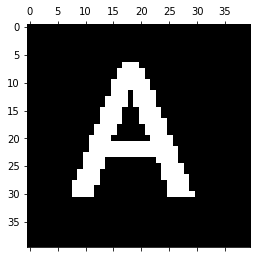

<Figure size 432x288 with 0 Axes>

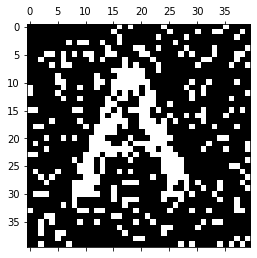

(99, True, 0.83625)

In [8]:
a = GenerateArrayFromImage('sample-images/a.jpeg', plot=True, flaw_intensity=.2)
a.run()
k0 = 2 * a.image_array.ravel() - 1
k1 = 2 * a.flaw_array.ravel() - 1
h = Hebbian(k0, k1, max_iterations=100)
h.run()
similarity = (k0 == k1).sum() / k0.size
h.max_iterations, h.has_converged(), similarity

# Find inner cycles
We saw that when similarity is under 50% the the network is not able anymore to converge and it exhausts all the loops. In such cases we might want to find inner cycles, that is, when the network returns to a previous set of values.
As we have this functionality implemented in the code we can run a bunch of experiments to notice what is the max number of iterations it takes for a newtwork to either converge or find a loop before converging.

In [9]:
size = 400
no_of_experiments = 400
has_converged, iterations = list(), list()
np.random.seed(10)
for _ in range(no_of_experiments):
    k0 = 2 * np.random.binomial(1, .4, size=size) - 1
    k1 = 2 * np.random.binomial(1, .6, size=size) - 1
    h = Hebbian(k0, k1, max_iterations=100)
    h.run()
    h.max_iterations, h.has_converged(), h.looped_back_to_initial(), similarity
    has_converged.append(h.has_converged())
    iterations.append(len(h.history))
outcomes = pd.DataFrame({
    'has_converged': has_converged,
    'iterations': iterations,
    'id': np.arange(no_of_experiments)
})
outcomes.groupby(['has_converged', 'iterations']).count()

,,id
has_converged,iterations,
False,3,332
True,2,68


Playing with above we can see that the it takes to the network one cycle to converge or diverge (as the first row in the history array is the flawed image)

# Several --random and independent-- patterns

In [96]:
2 * np.random.randint(0, 2) - 1
2 * np.random.uniform() -1

several_patterns = 2 * np.array([
    np.random.binomial(1, p, size=size) for p in np.linspace(.1, .9, 5)
]) -1
2 * patterns -1

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1,  1, -1, ..., -1, -1, -1],
       [ 1,  1,  1, ...,  1, -1,  1],
       [ 1,  1,  1, ...,  1,  1, -1],
       [ 1, -1,  1, ...,  1,  1,  1]])

In [113]:
def self_similarity(array):
    """
    Determine the ratio of the coincidences in an array.
    
    Sometimes we might want how similar rows in a matrix are, more precisely what is the
    matching ratio between rows.
    
    Args:
        * array: a mxn numpy array 
        
    Returns:
        * a mxm array
    
    Given a matrix m:
    m = np.array([
        [1, 2, 3],  # 1
        [1, 3, 3],  # 2
        [0, 2, 1],  # 3
        [0, 0, 0]   # 4
    ])
    The self_similarity then is
    ss = np.array([
        [1, 2/3, 1/3, 0]  # 11, 12, 13, 14
        [2/3, 1, 0, 0]    # 21, 22, 23, 24
        [1/3, 0, 1, 1/3]  # 31, 32, 33, 34
        [0, 0, 1/3, 1]    # 41, 42, 43, 44
    ])
    """
    self_similarity = list()
    output_size = (array.shape[0], array.shape[0])
    for pattern in array:
        for target in array:
            self_similarity.append((pattern == target).sum())
    ss = np.array(self_similarity).reshape(5, 5) / max(self_similarity)
    return ss

size = 100
np.random.seed(10)
several_patterns_1 = 2 * np.random.binomial(1, .5, size=(5, size)) - 1
several_patterns_2 = 2 * np.random.randint(0, 2, size=(5, size)) - 1
several_patterns_3 = 2 * np.random.binomial(1, np.random.uniform(size=size), size=(5, size)) - 1
several_patterns_4 = 2 * np.array([
    np.random.binomial(1, p, size=size) for p in np.linspace(.1, .9, 5)
]) -1
self_similarity(several_patterns_1).mean(axis=1), self_similarity(several_patterns_4).mean(axis=1)
self_similarity(several_patterns_4)


In [103]:
np.cov(several_patterns.T)

array([[1.2, 0.2, 0.2, ..., 0.2, 0.2, 0.4],
       [0.2, 1.2, 1.2, ..., 1.2, 1.2, 0.4],
       [0.2, 1.2, 1.2, ..., 1.2, 1.2, 0.4],
       ...,
       [0.2, 1.2, 1.2, ..., 1.2, 1.2, 0.4],
       [0.2, 1.2, 1.2, ..., 1.2, 1.2, 0.4],
       [0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.8]])

In [25]:
k1 = alter_array(k0, n)
# h = Hebbian(several_patterns, )

# Multiple images

<Figure size 432x288 with 0 Axes>

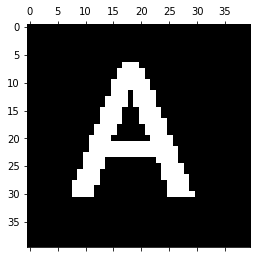

<Figure size 432x288 with 0 Axes>

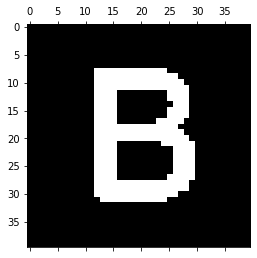

<Figure size 432x288 with 0 Axes>

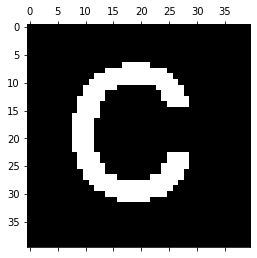

<Figure size 432x288 with 0 Axes>

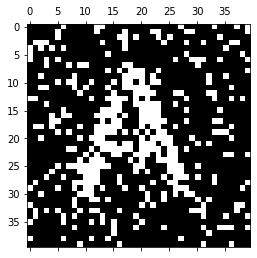

In [10]:
# Generate the image arrays
a = GenerateArrayFromImage('sample-images/a.jpeg', flaw_intensity=.2)
b = GenerateArrayFromImage('sample-images/b.jpeg', flaw_intensity=.2)
c = GenerateArrayFromImage('sample-images/c.jpeg', flaw_intensity=.2)
letters = [a, b, c]
[letter.run() for letter in letters]

# Plot what we have so far
[letter.plot_bitmap(letter.image_array) for letter in letters]
letters[0].plot_bitmap(letters[0].flaw_array)

# Create the input for the Hebbian class
k0 = np.array(
    [2 * letter.image_array.ravel() -1 for letter in letters]
)
k1 = 2 * letters[0].flaw_array.ravel() - 1

In [11]:
h = Hebbian(k0, k1, max_iterations=100)
h.run()
similarity = (k0[0] == k1).sum() / k0[0].size
h.max_iterations, h.has_converged(), similarity

(98, False, 0.83)

In [12]:
(h.history[-1] == k0[1]).all()
(h.history[-1] == h.history[-2]).all()

True